In [3]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import sklearn as sk
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [5]:
# Считывание данных
weather_data = pd.read_csv('weather data chernov.csv')

weather_data = weather_data.rename(columns = {'time': 'Date'})
weather_data.Date = pd.to_datetime(weather_data.Date, format='ISO8601', errors='coerce')

In [7]:
generation_data = pd.read_excel("Данные ОИК Черновская СЭС 01.05.2024 - 14.12.2024.xlsx")
new_column = generation_data.iloc[:,1] + generation_data.iloc[:,2]
generation_data = generation_data.drop(generation_data.columns[[1,2]], axis=1)
generation_data = generation_data.drop(0)
generation_data.insert(1, 'ПГБР Pген ГОУ Черновская', new_column)
columns_name = ['Date', 'Plan_X-1_Pgen', 'Fact_Pgen', 'Forecast_15_min', 'Forecast_30_min', 'Forecast_45_min', 'Forecast_60_min',
               'Forecast_2_hour', 'Forecast_3_hour', 'Forecast_4_hour', 'Insolation', "Temperature", 'Wind_speed']
generation_data.columns = columns_name
generation_data = generation_data.reset_index(drop=True)
generation_data.Date = pd.to_datetime(generation_data.Date)

In [8]:
# Whether_data and Pgen mearging
Pgen = generation_data[['Date', 'Fact_Pgen']] #из данных СО нужна только генерация
data_merge = pd.merge(Pgen, weather_data, on='Date', how='left').drop_duplicates('Date') # Date is usefull for Merge
data = data_merge.drop('Date', axis=1) # после слияние дата не нужна
data = data.drop('shortwave_radiation_instant (W/m²)', axis=1) # shortwave is a sum of direct and diffuse radiation
data = data.dropna()
data['temperature_2m (°C)'] = data['temperature_2m (°C)'].astype(float) # was string format
data['Fact_Pgen'] = pd.to_numeric(data['Fact_Pgen'], errors='raise')
data = data.reset_index(drop=True)  # final dataset for model building

In [9]:
# Fiting on the SO weather data
generation_data_weather = generation_data[['Fact_Pgen', 'Insolation', 'Temperature', 'Wind_speed']]
data = generation_data_weather.dropna()
data['Fact_Pgen'] = pd.to_numeric(data['Fact_Pgen'], errors='raise')

C:\Users\evb36\AppData\Local\Temp\ipykernel_12812\1674013401.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Fact_Pgen'] = pd.to_numeric(data['Fact_Pgen'], errors='raise')


In [1194]:
data = data.drop(['Temperature', 'Wind_speed'], axis=1)

In [13]:
# Разделение данных на обучающую и тестовую выборки
y = data.Fact_Pgen#.to_numpy()
# y = np.asarray(y, dtype=float)
X = data.drop('Fact_Pgen', axis=1)#.to_numpy()
#X = np.asarray(X, dtype=float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_features = X.shape[1] #control number of features

# Нормализация данных
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Наиболее оптимальные параметры

Dropout лучше не использовать или минимальные значения 0.2
Первый слой  - 
Второй слой - 
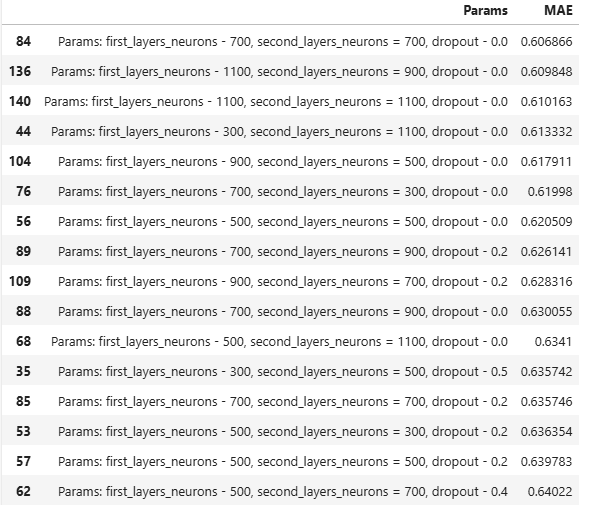

Наихудшие результаты у НС с функцией активации первого скрытого слоя - сигмоиды
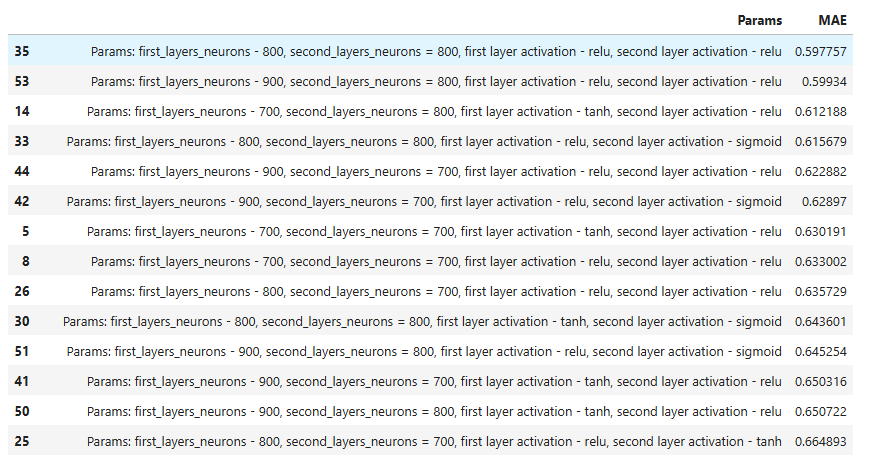

## Расчёты

In [15]:
def MLP_creater (first_hidden_layer_neurons, second_hidden_layer_neurons, first_hidden_layer_activation = 'tanh', second_hidden_layer_activation = 'relu', dropout=0.2, 
                 input_dim=n_features, loss='mae', optimizer='adam'):
    # Создание модели MLP
    model = Sequential()
    model.add(Dense(first_hidden_layer_neurons, input_dim = n_features, activation=first_hidden_layer_activation)) # Первый скрытый слой
    model.add(Dense(second_hidden_layer_neurons, activation=second_hidden_layer_activation)) # Второй скрытый слой
    model.add(Dropout(dropout)) # Вероятность отключения нейрона = значинию Dropout
    model.add(Dense(1)) # Выходной слой (регрессия)
    
    # Компиляция модели
    model.compile(optimizer=optimizer, loss=loss)#, metrics=['mse'])
    return model

In [213]:
# Фиксирую оптимальные параметры
model = Sequential()
model.add(Dense(800, input_dim = n_features, activation='relu')) # Первый скрытый слой
model.add(Dense(800, activation='relu')) # Второй скрытый слой
# model.add(Dropout(0.2)) # Вероятность отключения нейрона = значинию Dropout
model.add(Dense(1)) # Выходной слой (регрессия)

# Компиляция модели
model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])

C:\Users\evb36\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [481]:
%%time
# выбор оптимальных параметров НС
# import warnings
# warnings.filterwarnings('ignore')
fit_id = 0
mae_dict = {}
for first_layers_neurons in range (700, 901, 100): # создаются вложенные циклы для каждого параметра
    for second_layers_neurons in range (700, 801, 100):
        for first_layers_activation in ['sigmoid', 'tanh', 'relu']:
            for second_layers_activation in ['sigmoid', 'tanh', 'relu']:
                model = MLP_creater(first_layers_neurons, second_layers_neurons, dropout=0.0, 
                                    first_hidden_layer_activation=first_layers_activation, second_hidden_layer_activation=second_layers_activation)
                fiting_history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)
                mae_dict[fit_id] = [f'Params: first_layers_neurons - {first_layers_neurons}, second_layers_neurons = {second_layers_neurons}, first layer activation - {first_layers_activation}, second layer activation - {second_layers_activation}', 
                                   fiting_history.history['val_loss'][-1]]
                fit_id += 1
results = pd.DataFrame(mae_dict).transpose()
results.columns = ['Params', 'MAE']

CPU times: total: 1h 43min 2s
Wall time: 17min 33s


In [2]:
# pd.set_option('display.max_colwidth', None) # raise max wdth of pandas column
# results.sort_values(by=['MAE'])#.head(50)

In [215]:
# Обучение модели
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test), verbose=2)

Epoch 1/3
274/274 - 2s - 8ms/step - loss: 1.3524 - mae: 1.3524 - mse: 12.0163 - val_loss: 0.7376 - val_mae: 0.7376 - val_mse: 3.6460
Epoch 2/3
274/274 - 1s - 4ms/step - loss: 0.7826 - mae: 0.7826 - mse: 3.9758 - val_loss: 0.8320 - val_mae: 0.8320 - val_mse: 3.4755
Epoch 3/3
274/274 - 1s - 4ms/step - loss: 0.7279 - mae: 0.7279 - mse: 3.7031 - val_loss: 0.6364 - val_mae: 0.6364 - val_mse: 3.0548


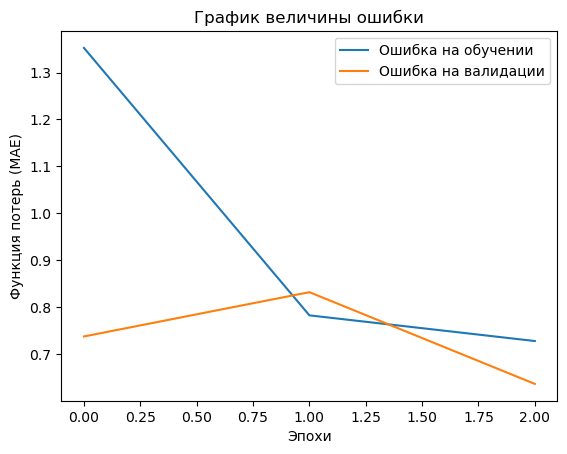

In [217]:
# Визуализация процесса обучения
plt.plot(history.history['loss'], label='Ошибка на обучении')
plt.plot(history.history['val_loss'], label='Ошибка на валидации')
plt.title('График величины ошибки')
plt.xlabel('Эпохи')
plt.ylabel('Функция потерь (MAE)')
plt.legend()
plt.show()

In [219]:
# Метрики на всей тестовой выборке
y_pred = model.predict(X_test)
mae = metrics.mean_absolute_error(y_test, y_pred)
# mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
print(f"""MAE is {mae} 
MSE is {mse}""")

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
MAE is 0.6364441033027398 
MSE is 3.054765707753729


In [223]:
# Оценка модели на интервале
min_interval = 2470
max_interval = 2570
X_interval = scaler.transform(X[min_interval:max_interval])
y_pred = model.predict(X_interval)
y_interval = y[min_interval:max_interval].reset_index(drop=True)
mae = metrics.mean_absolute_error(y_interval, y_pred)
print(f"Средняя абсолютная ошибка (MAE) на интервале тестовых данных: {mae}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Средняя абсолютная ошибка (MAE) на интервале тестовых данных: 0.8747015782818204


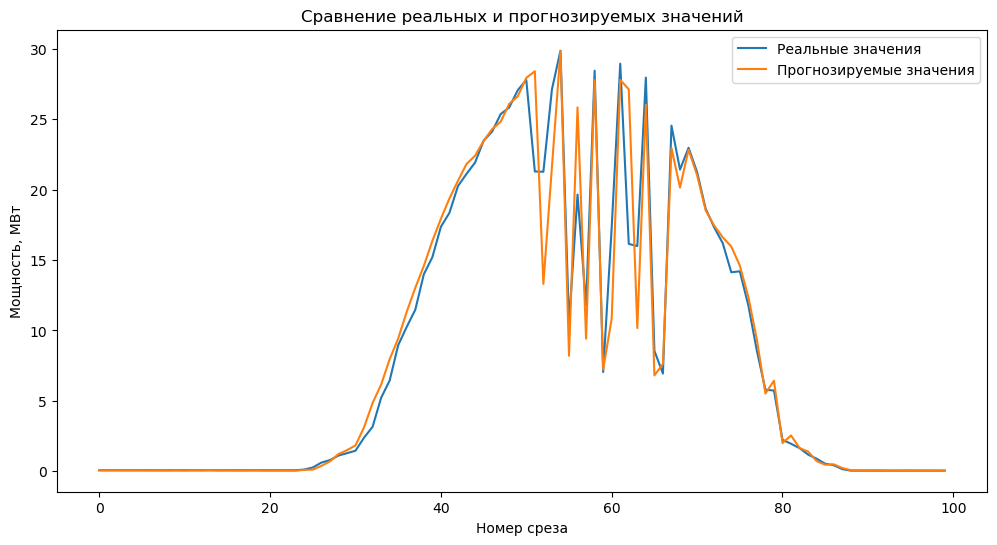

In [225]:
import seaborn as sns
# Визуализация результатов
plt.figure(figsize=(12,6))
plt.plot(y_interval, label='Реальные значения')
plt.plot(y_pred, label='Прогнозируемые значения')
plt.title('Сравнение реальных и прогнозируемых значений')
plt.xlabel('Номер среза')
plt.ylabel('Мощность, МВт')
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Средняя абсолютная ошибка (MAE) на интервале тестовых данных: 0.3748775400221357


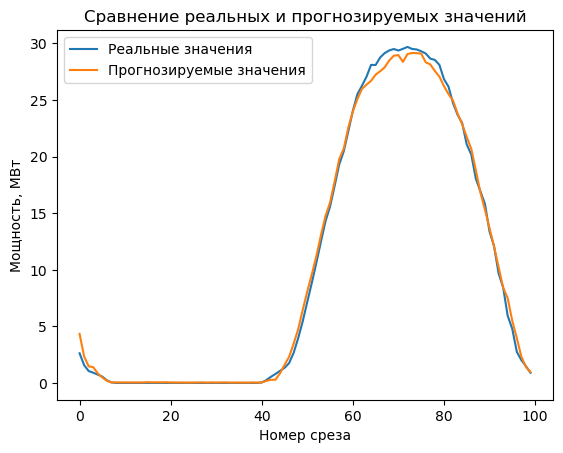

In [227]:
min_interval = 2070
max_interval = 2170
X_interval = scaler.transform(X[min_interval:max_interval])
y_pred = model.predict(X_interval)
y_interval = y[min_interval:max_interval].reset_index(drop=True)
mae = metrics.mean_absolute_error(y_interval, y_pred)
print(f"Средняя абсолютная ошибка (MAE) на интервале тестовых данных: {mae}")

plt.plot(y_interval, label='Реальные значения')
plt.plot(y_pred, label='Прогнозируемые значения')
plt.title('Сравнение реальных и прогнозируемых значений')
plt.xlabel('Номер среза')
plt.ylabel('Мощность, МВт')
plt.legend()
plt.show()